# Employee Turnover Analytics

### Project Statement:
Portobello Tech is an app innovator that has devised an intelligent way of predicting employee turnover within the company. It periodically evaluates employees' work details including the number of projects they worked upon, average monthly working hours, time spent in the company, promotions in the last 5 years, and salary level.
Data from prior evaluations show the employee’s satisfaction at the workplace. The data could be used to identify patterns in work style and their interest to continue to work in the company. 
The HR Department owns the data and uses it to predict employee turnover. Employee turnover refers to the total number of workers who leave a company over a certain time period.
As the ML Developer assigned to the HR Department, you have been asked to create ML Programs  to :

* Perform data quality check by checking for missing values if any.
* Understand what factors contributed most to employee turnover by EDA.
* Perform clustering of Employees who left based on their satisfaction and evaluation.
* Handle the left Class Imbalance using SMOTE technique.
* Perform k-fold cross-validation model training and evaluate performance. 
* Identify the best model and justify the evaluation metrics used. 
* Suggest various retention strategies for targeted employees.


Data will be modified from: 
https://www.kaggle.com/liujiaqi/hr-comma-sepcsv



#### Column Name     	      : Description

satisfaction_level        : satisfaction level at the job of an employee

last_evaluation	          : Rating between 0 to 1, received by an employee at his last evaluation

number_project	          : Number of projects, an employee involved in

average_montly_hours	  : Average number of hours in a month, spent by an employee at office

time_spend_company	      : Number of years spent in the company

Work_accident	          : 0 - no accident during employee stay, 1 - accident during employee stay

left	                  : 0 indicates employee stays in the company, 1 indicates - employee left the company

promotion_last_5years	  : Number of promotions in his stay

Department	              : Department, an employee belongs to

salary	                  : Salary in USD

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay,classification_report,make_scorer,confusion_matrix,accuracy_score

In [2]:
# uploading dataset to python environment
data = pd.read_excel('hr_comma_sep.xlsx')
data.head(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
# dispalying basic information of dataset
print("Shape of dataset is : ", data.shape)
print(data.info())

Shape of dataset is :  (14999, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None


From the primary analysis there is no null values in the dataset. Need further analysis to check whether there is any mismatch in data.

In [4]:
# renaming column sales with department, clearing spelling mistake
data.rename(columns={'sales':'department','average_montly_hours':'average_monthly_hours'},inplace=True)

In [5]:
# displaying unique values in columns and its counts
col = data.columns

for i in col:
    vc=data[i].value_counts()
    vc=pd.DataFrame(vc)
    print(i,vc)

satisfaction_level                     count
satisfaction_level       
0.10                  358
0.11                  335
0.74                  257
0.77                  252
0.84                  247
...                   ...
0.25                   34
0.28                   31
0.27                   30
0.26                   30
0.12                   30

[92 rows x 1 columns]
last_evaluation                  count
last_evaluation       
0.55               358
0.50               353
0.54               350
0.51               345
0.57               333
...                ...
0.39                52
0.43                50
0.38                50
0.44                44
0.36                22

[65 rows x 1 columns]
number_project                 count
number_project       
4                4365
3                4055
5                2761
2                2388
6                1174
7                 256
average_monthly_hours                        count
average_monthly_hours       
135        

While analyzing the unique values in each column, didn't observe any mismatch in data.

In [6]:
# printing the number of employees left and remained in company
print("Number of employees continued to work (indicated by 0) and left (indicated by 1): \n", data['left'].value_counts())
print("Percentage turnover : ",((data['left']==1).sum()/(data.shape[0]))*100)

Number of employees continued to work (indicated by 0) and left (indicated by 1): 
 left
0    11428
1     3571
Name: count, dtype: int64
Percentage turnover :  23.80825388359224


This indicates that this is a an imbalanced dataset. We have to use different methods to improve the predictions of the model.

In [7]:
# categorising data wrt dypes
num_data = data.select_dtypes(include=np.number)
cat_data = data.select_dtypes(include= object)

In [8]:
# basic statsitical analysis of both numerical and categorical data
num_data.describe().T

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,14999.0,0.612834,0.248631,0.09,0.44,0.64,0.82,1.0
last_evaluation,14999.0,0.716102,0.171169,0.36,0.56,0.72,0.87,1.0
number_project,14999.0,3.803054,1.232592,2.00,3.00,4.00,5.00,7.0
average_monthly_hours,14999.0,201.050337,49.943099,96.00,156.00,200.00,245.00,310.0
time_spend_company,14999.0,3.498233,1.460136,2.00,3.00,3.00,4.00,10.0
Work_accident,14999.0,0.144610,0.351719,0.00,0.00,0.00,0.00,1.0
left,14999.0,0.238083,0.425924,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,14999.0,0.021268,0.144281,0.00,0.00,0.00,0.00,1.0


In [9]:
cat_data.describe().T

,count,unique,top,freq
department,14999,10,sales,4140
salary,14999,3,low,7316


### Explanatory Data Analysis

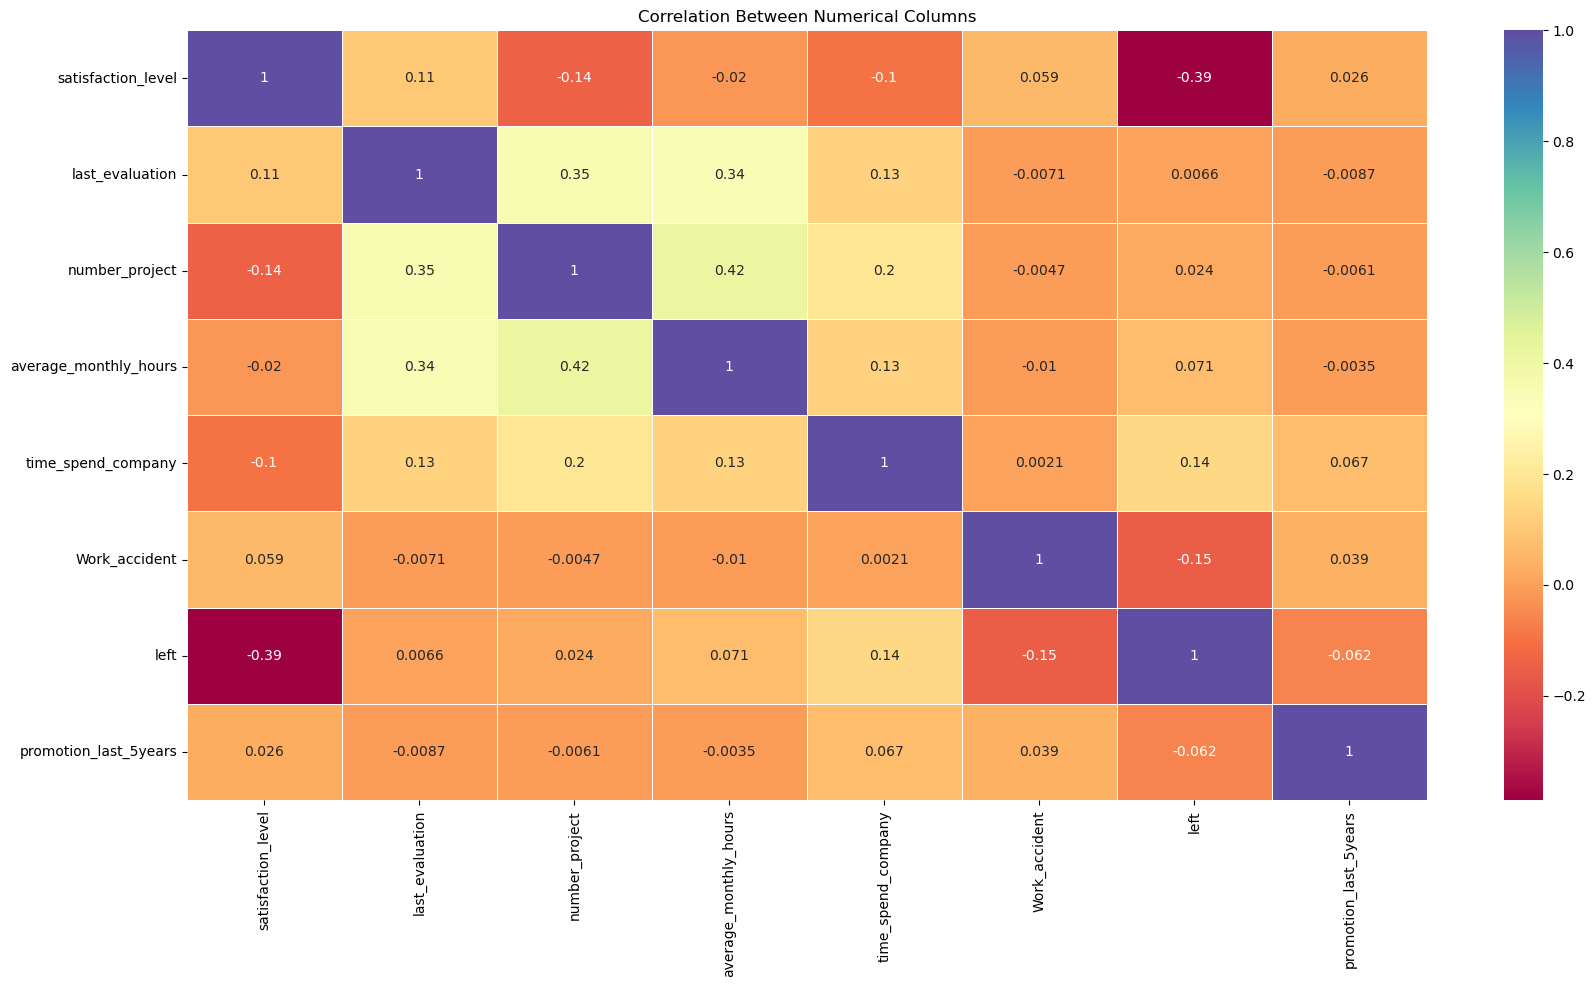

In [10]:
# heatmap of the Correlation Matrix between all numerical features/columns in the data.

corr_matrix = num_data.corr()
plt.figure(figsize=(20,10))
plt.title('Correlation Between Numerical Columns')
sns.heatmap(corr_matrix,annot=True,xticklabels=True, yticklabels=True,linewidth=.5,cmap='Spectral')
plt.show()

The correlation coefficeints values are in moderate range hence the chances of multicolinearity is low.

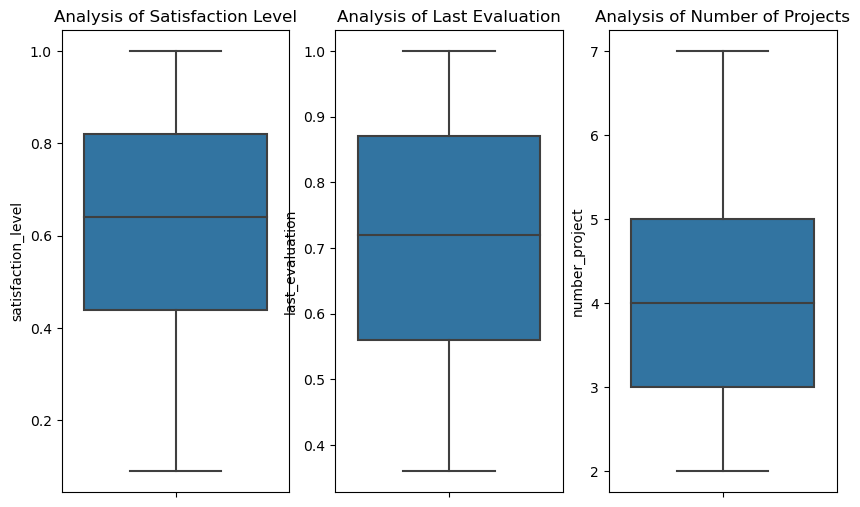

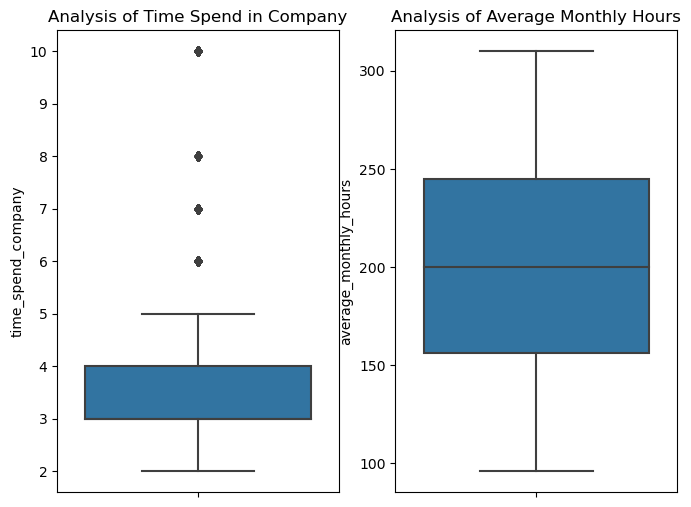

In [11]:
# Outlier detection
fig=plt.figure(figsize=(10,6))
plt.subplot(1,3,1)
sns.boxplot(y=data['satisfaction_level'],data=data);
plt.title('Analysis of Satisfaction Level')
plt.xticks(rotation=90)
plt.subplot(1,3,2)
sns.boxplot(y='last_evaluation',data=data);
plt.title('Analysis of Last Evaluation')
plt.subplot(1,3,3)
sns.boxplot(y='number_project',data=data);
plt.title('Analysis of Number of Projects');

fig=plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
sns.boxplot(y=data['time_spend_company'],data=data);
plt.title('Analysis of Time Spend in Company')
plt.xticks(rotation=90)
plt.subplot(1,2,2)
sns.boxplot(y='average_monthly_hours',data=data);
plt.title('Analysis of Average Monthly Hours');

* There are outliers in time spend in company. Need to treat those outliers.

D:\Aconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


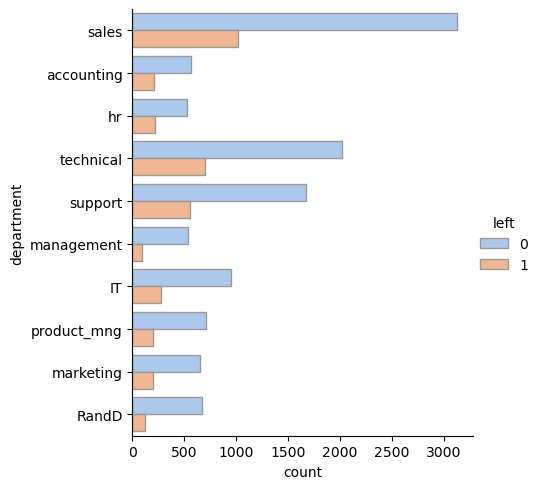

In [12]:
# analysis of department Vs left
sns.catplot(data=data, y="department", hue="left", kind="count",palette="pastel", edgecolor=".6");

* In every department the number of employees left is less than 50%.
* From the above plot the chances of employees leaving is high for HR department compared to others.
* RanD and management department have low percentage of employees left.


In [13]:
# Displaying the percentage of employees left and continued in each department
data_d = data.groupby(['department','left']).agg({'left':'count'})
data_d['Percentage'] = 100 * data_d['left'] / data_d.groupby('department')['left'].transform('sum')
data_d

left  Percentage
department  left                  
IT          0      954   77.750611
            1      273   22.249389
RandD       0      666   84.625159
            1      121   15.374841
accounting  0      563   73.402868
            1      204   26.597132
hr          0      524   70.906631
            1      215   29.093369
management  0      539   85.555556
            1       91   14.444444
marketing   0      655   76.340326
            1      203   23.659674
product_mng 0      704   78.048780
            1      198   21.951220
sales       0     3126   75.507246
            1     1014   24.492754
support     0     1674   75.100942
            1      555   24.899058
technical   0     2023   74.375000
            1      697   25.625000

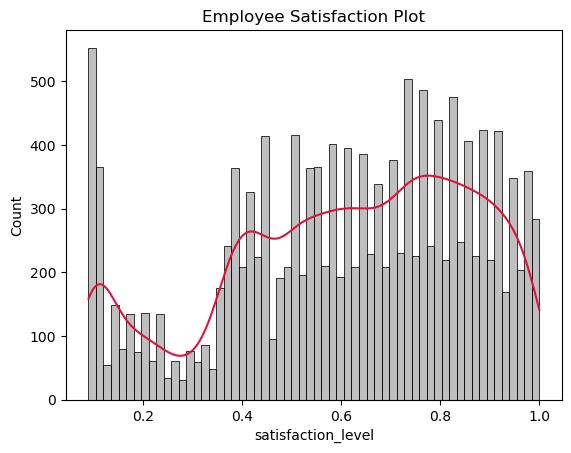

In [14]:
# Employee satisfaction plot
ax=sns.histplot(data['satisfaction_level'], kde = True, color ='grey', bins = 60)
ax.lines[0].set_color('crimson')
plt.title("Employee Satisfaction Plot");

* The average value of satisfaction level is 0.61
* From the above plot it's clear that the number of employees with low satisfaction is the most. Then there is decrease in the count as the as satisfaction level increases.
* At around 0.4 satisfaction level the count of employees increases until around 0.8.
* After that there is a sharp decrese in number of employees with higher satisfaction level. 

In [15]:
print("Number of employees with satisfaction level in mid range is : ", 
      (data.satisfaction_level<=0.82).sum()-(data.satisfaction_level<0.44).sum())
print("Number of employees with satisfaction level less than 0.6 : ",(data.satisfaction_level<=0.6).sum())
print("Number of employees with satisfaction level greater than 0.6 : ",(data.satisfaction_level>0.6).sum())
print("Number of employees with satisfaction level less than 0.1 : ",(data.satisfaction_level<0.1).sum())
print("Number of employees with satisfaction level equal to 1 : ",(data.satisfaction_level== 1).sum())

Number of employees with satisfaction level in mid range is :  7784
Number of employees with satisfaction level less than 0.6 :  6729
Number of employees with satisfaction level greater than 0.6 :  8270
Number of employees with satisfaction level less than 0.1 :  195
Number of employees with satisfaction level equal to 1 :  111


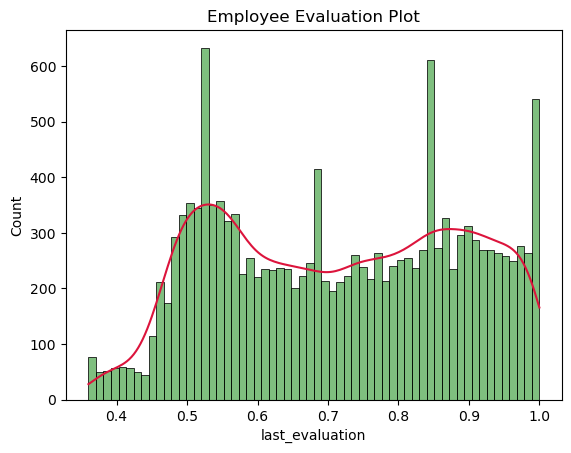

In [16]:
# Employee Evaluation plot
ax=sns.histplot(data['last_evaluation'], kde = True, color ='green', bins = 60)
ax.lines[0].set_color('crimson')
plt.title("Employee Evaluation Plot");

* The average value of last evaluation rating is 0.7.
* The last evaluation rating for employees steadily increases untill 0.53.
* Most number of employees have 0.53 last evaluation rating which is less than the average value.
* After that the rating value decreases slowly, in between there is sudden shoot in employee counts at 0.69,0.85 and 1.

In [17]:
print("Number of employees with last evaluation rating in mid range is : ",
      ((data.last_evaluation<=0.87).sum())-((data.last_evaluation<0.56).sum()))
print("Number of employees with last evaluation less than 0.7 : ",(data.last_evaluation<=0.7).sum())
print("Number of employees with last evaluation greater than 0.7 : ",(data.last_evaluation>0.7).sum())
print("Number of employees with last evaluation less than 0.53 : ",(data.last_evaluation<=0.53).sum())
print("Number of employees with last evaluation equal to 1 : ",(data.last_evaluation==1).sum())

Number of employees with last evaluation rating in mid range is :  7873
Number of employees with last evaluation less than 0.7 :  7197
Number of employees with last evaluation greater than 0.7 :  7802
Number of employees with last evaluation less than 0.53 :  2899
Number of employees with last evaluation equal to 1 :  283


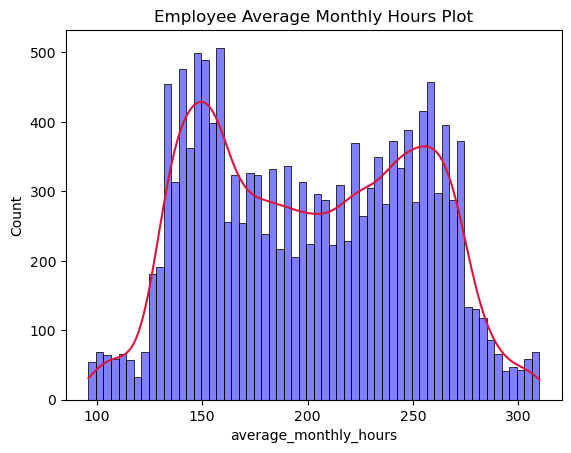

In [18]:
# Employee Average Monthly Hours plot
ax=sns.histplot(data['average_monthly_hours'], kde = True, color ='blue', bins = 60)
ax.lines[0].set_color('crimson')
plt.title("Employee Average Monthly Hours Plot");

* The average value of hours spent at office is about 201. Most number of employees lies in this range as expected.
* From around 100 hours the number of employees increases steadily with hours spent at office until 150 hours.
* After that the number of employees decrease with increase in hours spent until around 220 hours.
* After 220 the number of employees inceases with increase in hours spent until the second maximum number in employees, which is around 270 hours.
* After 270 there is sharp decrease in number of employees in hours spent at office.

In [19]:
print("Number of employees who spent hours less than 201 : ",(data.average_monthly_hours<=201).sum())
print("Number of employees who spent hours greater than 201 : ",(data.average_monthly_hours>201).sum())
print("Number of employees who spent least hours at office : ",(data.average_monthly_hours==96).sum())
print("Number of employees who spent most hours at office : ",(data.average_monthly_hours==310).sum())
print("Number of employees who spent hours at office in the mid average range  : ",
      (data.average_monthly_hours<=245).sum()-(data.average_monthly_hours<156).sum())

Number of employees who spent hours less than 201 :  7610
Number of employees who spent hours greater than 201 :  7389
Number of employees who spent least hours at office :  6
Number of employees who spent most hours at office :  18
Number of employees who spent hours at office in the mid average range  :  7628


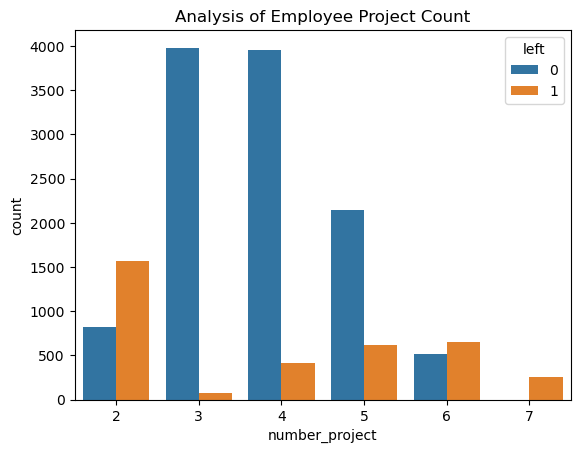

In [20]:
# plotting number of projects in employees are involved
sns.countplot(x='number_project',data=data,hue='left');
plt.title('Analysis of Employee Project Count');

* From the above plot its clear that most employees who are involved in least number of project, 2, left the company. It indicates that may be they are the under performers. Their involvement in different projects are limited because of their performance.
* The average value of number of projects is around 4. From the above plot it's clear that , most of the employees are involved in either 3 or 4 or 5 projects. And those who are in this range continues to work in the company so their performance ratings will also be good.
* Most of those who are involved in 6 projects left the company. This may be due to work pressure or of work life imbalance.
* Everyone who were involved in 7 projects left the company. This indicates high work pressure or  work life imbalance.
* From this we can infer that as work pressure increases employees tends to leave the company. Or else we can say that they left the company for better opportunities.

In [21]:
# Tabulating the number of employees who stayed and left the company, who were involved in different number of projects
data.groupby(['number_project','left']).agg({'left':'count'})

left
number_project left      
2              0      821
               1     1567
3              0     3983
               1       72
4              0     3956
               1      409
5              0     2149
               1      612
6              0      519
               1      655
7              1      256

####  Perform clustering of Employees who left based on their satisfaction and evaluation.

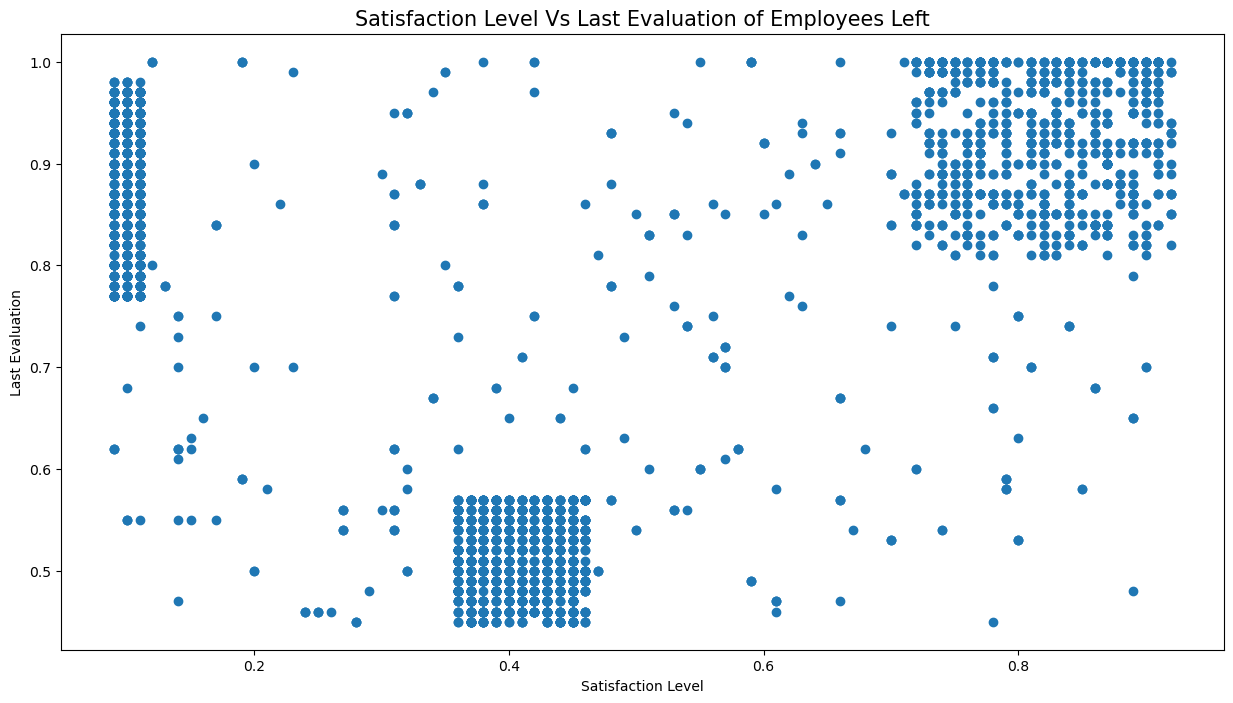

In [22]:
# creating a new dataset of employees who left.
data_left =data[data.left==1]

#creating a scatter plot for satisfaction level and last evaluation
plt.figure(figsize=(15,8))
plt.scatter(data_left['satisfaction_level'],data_left['last_evaluation'])
plt.title("Satisfaction Level Vs Last Evaluation of Employees Left",fontsize=15)
plt.xlabel("Satisfaction Level")
plt.ylabel("Last Evaluation");

* Turnover is high for employees with both rating for last evaluation and satisfaction level high. They left the company   may be to search for better opportunities. Or else we can say that they got better offers from other companies. 
* Employee turnover is high for those with high rating in last evaluation and low satisfaction level. They are leaving the firm because they are not happy there.
* We can observe that employee turnover is also high for those with satisfaction in and around 0.4 and whose last evaluation rating is less than 0.6. We can't be certain about why they left. But can assume that they changed their domain or the company to find a opening where they can perform well. Or we can say that they took a break to upskill.

##### Do KMeans clustering of employees who left the company into 3 clusters.

In [23]:
# Kmeans clustering
model=KMeans(n_clusters=3, init='k-means++',random_state=42)
y_kmeans=model.fit_predict(data_left.iloc[:,[0,1]].values)

D:\Aconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


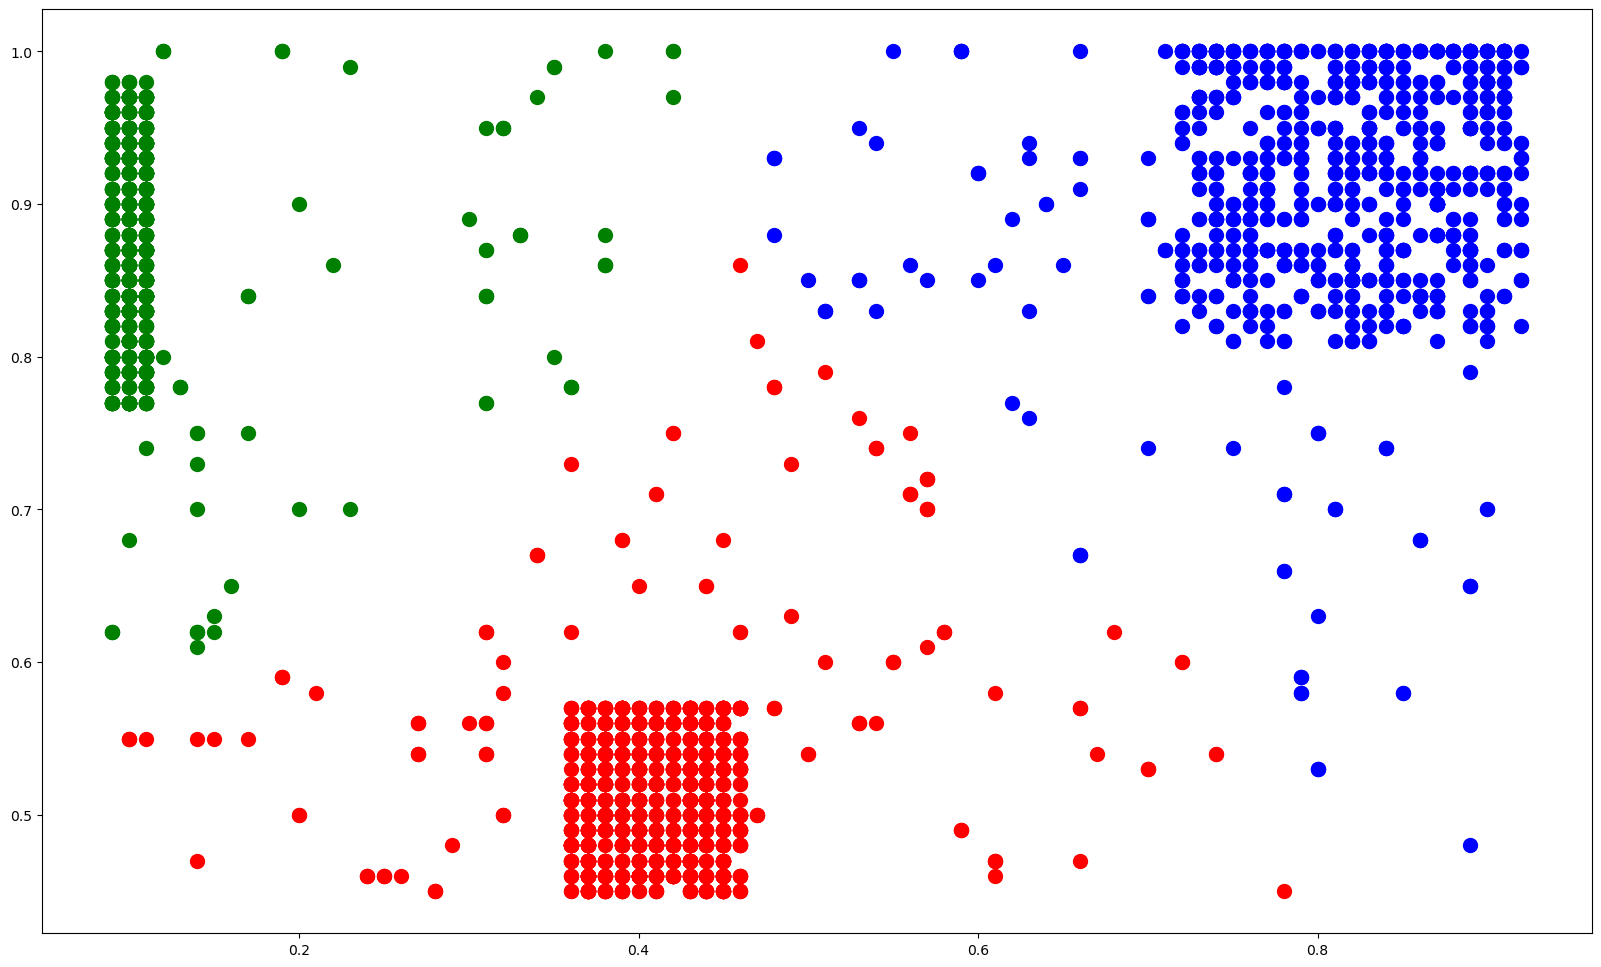

In [24]:
# plotting the K means clustering
X=data_left.iloc[:,[0,1]].values
plt.figure(figsize=(20,12))
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3');

* K means clustering for  3 is similar to the scatter plot above. The data points nearer to each clusters are assigned to that particular one.
* The observations are listed below the scatter plot earlier.
    * Turnover is high for employees with both rating for last evaluation and satisfaction level high. They left the company   may be to search for better opportunities. Or else we can say that they got better offers from other companies. 
    * Employee turnover is high for those with high rating in last evaluation and low satisfaction level. They are leaving the firm because they are not happy there.
    * We can observe that employee turnover is also high for those with satisfaction in and around 0.4 and whose last evaluation rating is less than 0.6. We can't be certain about why they left. But can assume that they changed their domain or the company to find a opening where they can perform well. Or we can say that they took a break to upskill.

### Preprocessing

In [25]:
# saving the cleaned dataset 
cleaned_data = data

In [26]:
# Analysing and handling the outliers in Time Spend company
Q1=np.percentile(data['time_spend_company'],25,interpolation='midpoint')
Q2=np.percentile(data['time_spend_company'],50,interpolation='midpoint')
Q3=np.percentile(data['time_spend_company'],75,interpolation='midpoint')

IQR=Q3-Q1
up_lim=Q3+1.5*IQR
low_lim=Q1-1.5*IQR
up_lim_extm = data.time_spend_company.quantile(0.75) + (IQR * 3)
print("The upper limit and upper limit extreme : ", up_lim,up_lim_extm)

outliers=[]
for i in data['time_spend_company']:
    if((i<low_lim)or(i>up_lim)):
        outliers.append(i)
#print(outliers)

print('Time Spend company > 7.0: {}'.format(data[data.time_spend_company>7.0].shape[0]))
print('Percentage of outliers: {}'.format(data[data.time_spend_company>7.0].shape[0]/float(data.shape[0])))

The upper limit and upper limit extreme :  5.5 7.0
Time Spend company > 7.0: 376
Percentage of outliers: 0.02506833788919261


C:\Users\dell\AppData\Local\Temp\ipykernel_13836\1126303946.py:2: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1=np.percentile(data['time_spend_company'],25,interpolation='midpoint')
C:\Users\dell\AppData\Local\Temp\ipykernel_13836\1126303946.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q2=np.percentile(data['time_spend_company'],50,interpolation='midpoint')
C:\Users\dell\AppData\Local\Temp\ipykernel_13836\1126303946.py:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'near

In [27]:
# limiting the upper extreme values to 7 for time spend company
data.loc[data.time_spend_company>7.0,'time_spend_company'] = 7.0
data.time_spend_company.max()

7

In [28]:
# Encoding non numeric columns
# One hot encoding
data = pd.get_dummies(data,columns=['salary','department'],drop_first=True, dtype=int)

data.head(5)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary_low,salary_medium,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,1,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,0,1,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,0,1,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,1,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [29]:
# scaling
from sklearn.preprocessing import StandardScaler
ns= StandardScaler()

s_data = data.drop(['left'],axis=1)
s_data= ns.fit_transform(s_data)
s_data=pd.DataFrame(s_data,columns=['satisfaction_level', 'last_evaluation', 'number_project','average_monthly_hours',
                                    'time_spend_company', 'Work_accident','promotion_last_5years', 'salary_low','salary_medium',
                                    'department_RandD', 'department_accounting', 'department_hr','department_management',
                                    'department_marketing','department_product_mng','department_sales','department_support',
                                    'department_technical'])
s_data.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,salary_low,salary_medium,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,-0.936495,-1.087275,-1.462863,-0.882040,-0.349944,-0.411165,-0.147412,1.024775,-0.868132,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655
1,0.752814,0.840707,0.971113,1.220423,2.011193,-0.411165,-0.147412,-0.975824,1.151898,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655
2,-2.022479,0.957554,2.593763,1.420657,0.437102,-0.411165,-0.147412,-0.975824,1.151898,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655
3,0.431041,0.899131,0.971113,0.439508,1.224148,-0.411165,-0.147412,1.024775,-0.868132,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655
4,-0.976716,-1.145699,-1.462863,-0.841993,-0.349944,-0.411165,-0.147412,1.024775,-0.868132,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655


In [30]:
# concatenating dataset after scaling
data= data.drop(['satisfaction_level', 'last_evaluation', 'number_project','average_monthly_hours','time_spend_company', 
                 'Work_accident','promotion_last_5years', 'salary_low','salary_medium','department_RandD', 
                 'department_accounting', 'department_hr','department_management','department_marketing',
                 'department_product_mng','department_sales','department_support','department_technical'],axis=1)
data= pd.concat([data,s_data],axis=1)
data.head()

,left,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,salary_low,salary_medium,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,1,-0.936495,-1.087275,-1.462863,-0.882040,-0.349944,-0.411165,-0.147412,1.024775,-0.868132,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655
1,1,0.752814,0.840707,0.971113,1.220423,2.011193,-0.411165,-0.147412,-0.975824,1.151898,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655
2,1,-2.022479,0.957554,2.593763,1.420657,0.437102,-0.411165,-0.147412,-0.975824,1.151898,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655
3,1,0.431041,0.899131,0.971113,0.439508,1.224148,-0.411165,-0.147412,1.024775,-0.868132,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655
4,1,-0.976716,-1.145699,-1.462863,-0.841993,-0.349944,-0.411165,-0.147412,1.024775,-0.868132,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.417791,-0.470655


### Handling imbalanced dataset

In [31]:
# splitting the dataset to target and features
x = data.drop(['left'],axis=1)
y = data['left']

In [32]:
# assigning training and testing values
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=123,test_size=.2,stratify=y)

In [33]:
# SMOTE : upsamplig thr train dataset
sm = SMOTE(random_state = 2) 
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel()) 

print('After OverSampling, the shape of train_X: {}'.format(x_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

After OverSampling, the shape of train_X: (18284, 18)
After OverSampling, the shape of train_y: (18284,) 

After OverSampling, counts of label '1': 9142
After OverSampling, counts of label '0': 9142


#### Perform 5-Fold cross-validation model training and evaluate performance.

In [34]:
# logistic regression
from sklearn.linear_model import LogisticRegression

loReg=LogisticRegression()
loReg=loReg.fit(x_train_res,y_train_res)
y_p=loReg.predict(x_test)

In [35]:
score_LR=loReg.score(x_test,y_test)
score_LR
print("Logistic regression score before CV :", score_LR)
print('Classification report :\n ',classification_report(y_test,y_p))

Logistic regression score before CV : 0.7763333333333333
Classification report :
                precision    recall  f1-score   support

           0       0.93      0.76      0.84      2286
           1       0.52      0.82      0.64       714

    accuracy                           0.78      3000
   macro avg       0.73      0.79      0.74      3000
weighted avg       0.83      0.78      0.79      3000



In [36]:
# K fold Cross Validation
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

# 5 Fold CV
kf_validator=KFold(5)

In [37]:
def classification_report_with_accuracy_score( y_train_res, y_pred):

    print(classification_report( y_train_res, y_pred)) # print classification report
    return accuracy_score( y_train_res, y_pred) # return accuracy score


In [38]:
# checking CV score : Logistic Regression Model
cv_lr_predict=cross_val_predict(loReg,x_train_res, y_train_res,cv=kf_validator)
cv_lr_result=cross_val_score(loReg,x_train_res, y_train_res,cv=kf_validator)
conf_mat = confusion_matrix(cv_lr_predict, y_train_res)
nested_score = cross_val_score(loReg,x_train_res, y_train_res,cv=kf_validator, \
               scoring=make_scorer(classification_report_with_accuracy_score))
print(nested_score)
#print("Logistic Regression Cross Validation result :",cv_lr_result)
print("Logistic Regression Cross Validation mean :",np.mean(cv_lr_result))
print("Logistic Rgression cross validation confusion matrix :\n",conf_mat)

              precision    recall  f1-score   support

           0       0.94      0.70      0.81      2794
           1       0.47      0.85      0.61       863

    accuracy                           0.74      3657
   macro avg       0.71      0.78      0.71      3657
weighted avg       0.83      0.74      0.76      3657

              precision    recall  f1-score   support

           0       0.96      0.71      0.82      2776
           1       0.50      0.90      0.64       881

    accuracy                           0.76      3657
   macro avg       0.73      0.80      0.73      3657
weighted avg       0.85      0.76      0.77      3657

              precision    recall  f1-score   support

           0       0.95      0.73      0.82      2785
           1       0.50      0.87      0.64       872

    accuracy                           0.76      3657
   macro avg       0.72      0.80      0.73      3657
weighted avg       0.84      0.76      0.78      3657

              preci

D:\Aconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Aconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Aconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Observations
* In order to avoid the the F1 score and Recall being ill defined and set to 0, choosing stratified cross validation instead of K fold cross validation

In [39]:
# Startified cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [40]:
# checking CV score : Logistic Regression Model with SCV
cv_lr_predict=cross_val_predict(loReg,x_train_res, y_train_res,cv=skf)
cv_lr_result=cross_val_score(loReg,x_train_res, y_train_res,cv=skf)
conf_mat = confusion_matrix(cv_lr_predict, y_train_res)
nested_score = cross_val_score(loReg,x_train_res, y_train_res,cv=skf, \
               scoring=make_scorer(classification_report_with_accuracy_score))
print(nested_score)
#print("Logistic Regression Cross Validation result :",cv_lr_result)
print("Logistic Regression Cross Validation mean :",np.mean(cv_lr_result))
print("Logistic Rgression cross validation confusion matrix :\n",conf_mat)

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1829
           1       0.77      0.84      0.80      1828

    accuracy                           0.79      3657
   macro avg       0.79      0.79      0.79      3657
weighted avg       0.79      0.79      0.79      3657

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1829
           1       0.79      0.81      0.80      1828

    accuracy                           0.80      3657
   macro avg       0.80      0.80      0.80      3657
weighted avg       0.80      0.80      0.80      3657

              precision    recall  f1-score   support

           0       0.81      0.74      0.78      1828
           1       0.76      0.83      0.79      1829

    accuracy                           0.79      3657
   macro avg       0.79      0.79      0.79      3657
weighted avg       0.79      0.79      0.79      3657

              preci

In [41]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
RF = RF.fit(x_train_res,y_train_res)
y_p=RF.predict(x_test)

score_RF=RF.score(x_test,y_test)
score_RF
print("Random Forest Classifier score before CV :", score_RF)
print('Classification report :\n ',classification_report(y_test,y_p))

Random Forest Classifier score before CV : 0.991
Classification report :
                precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.98      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [42]:
# checking CV Score for Random Forest Classifier with SCV
cv_rf_predict=cross_val_predict(RF,x_train_res, y_train_res,cv=skf)
cv_rf_result=cross_val_score(RF,x_train_res, y_train_res,cv=skf)
conf_mat = confusion_matrix(cv_rf_predict, y_train_res)
nested_score = cross_val_score(RF,x_train_res, y_train_res,cv=skf, \
               scoring=make_scorer(classification_report_with_accuracy_score))
print(nested_score)

cv_rf_result=cross_val_score(RF,x_train_res, y_train_res,cv=skf)
print("Random Forest Cross Validation result :",cv_rf_result)
print("Random Forest Cross Validation mean :",np.mean(cv_rf_result))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1829
           1       1.00      0.98      0.99      1828

    accuracy                           0.99      3657
   macro avg       0.99      0.99      0.99      3657
weighted avg       0.99      0.99      0.99      3657

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1829
           1       1.00      0.99      0.99      1828

    accuracy                           0.99      3657
   macro avg       0.99      0.99      0.99      3657
weighted avg       0.99      0.99      0.99      3657

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1828
           1       1.00      0.98      0.99      1829

    accuracy                           0.99      3657
   macro avg       0.99      0.99      0.99      3657
weighted avg       0.99      0.99      0.99      3657

              preci

In [43]:
# Gradient Boost Classifier
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb = gb.fit(x_train_res,y_train_res)
y_p=gb.predict(x_test)

score_gb=gb.score(x_test,y_test)
score_gb
print("Gradient Boost Classifier score before CV :", score_gb)
print('Classification report :\n ',classification_report(y_test,y_p))

Gradient Boost Classifier score before CV : 0.967
Classification report :
                precision    recall  f1-score   support

           0       0.98      0.98      0.98      2286
           1       0.93      0.94      0.93       714

    accuracy                           0.97      3000
   macro avg       0.95      0.96      0.95      3000
weighted avg       0.97      0.97      0.97      3000



In [44]:
# checking CV Score for Gradient Boosting Classifier with SCV

cv_gb_predict=cross_val_predict(gb,x_train_res, y_train_res,cv=skf)
cv_gb_result=cross_val_score(gb,x_train_res, y_train_res,cv=skf)
conf_mat = confusion_matrix(cv_gb_predict, y_train_res)
nested_score = cross_val_score(gb,x_train_res, y_train_res,cv=skf, \
               scoring=make_scorer(classification_report_with_accuracy_score))
print(nested_score)

cv_gb_result=cross_val_score(gb,x_train_res, y_train_res,cv=skf)

cv_gb_result=cross_val_score(gb,x_train_res, y_train_res,cv=skf)
#print("Gradient Boosting Cross Validation result :",cv_gb_result)
print("Gradient Booosting Cross Validation mean :",np.mean(cv_gb_result))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1829
           1       0.97      0.96      0.97      1828

    accuracy                           0.97      3657
   macro avg       0.97      0.97      0.97      3657
weighted avg       0.97      0.97      0.97      3657

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1829
           1       0.98      0.97      0.97      1828

    accuracy                           0.97      3657
   macro avg       0.97      0.97      0.97      3657
weighted avg       0.97      0.97      0.97      3657

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1828
           1       0.98      0.96      0.97      1829

    accuracy                           0.97      3657
   macro avg       0.97      0.97      0.97      3657
weighted avg       0.97      0.97      0.97      3657

              preci

### Identify the best model

In [45]:
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve

print('Confusion matrix and model comparison before Cross Validation')
accuracy = []
roc = []
model_used = ['Logistic Regression','Random Forest Classifier','Gradient Boosting Classifier']
models = [LogisticRegression(),RandomForestClassifier(),GradientBoostingClassifier()]

for i in models:
    i.fit(x_train_res,y_train_res)
    y_pred=i.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    roc.append(roc_auc_score(y_test, y_pred))
    print('Confusion Matrix - {} is \n {} '.format(i,confusion_matrix(y_test, y_pred)))
    
model_comparison = pd.DataFrame({'Model': model_used, 'Accuracy': accuracy, 'ROC AUC': roc})
model_comparison.sort_values(by='Accuracy', ascending=False)

Confusion matrix and model comparison before Cross Validation
Confusion Matrix - LogisticRegression() is 
 [[1744  542]
 [ 129  585]] 
Confusion Matrix - RandomForestClassifier() is 
 [[2276   10]
 [  15  699]] 
Confusion Matrix - GradientBoostingClassifier() is 
 [[2232   54]
 [  45  669]] 


,Model,Accuracy,ROC AUC
1,Random Forest Classifier,0.991667,0.987309
2,Gradient Boosting Classifier,0.967000,0.956676
0,Logistic Regression,0.776333,0.791116


#####  Observations
* Random forest classifier have the best performance on training data with accuracy 98% and ROC AUC .98
* Gradient Boosting classifier performance is slightly less than that of Random Forest Classifier, accuracy is 96% and ROC AUC is about .95
* Logistic Regression Classifier have the least performance with accuracy 77% and ROC AUC .78

#### Observations - After Stratified Cross Validation
* When we compare the performance Random Forest Classifier have better values compared to other classifier models

#### ROC for Startified Cross validation

In [46]:
from sklearn.metrics import RocCurveDisplay, auc

In [47]:
# function to plot ROC 

def Plot_ROC(classifier,cv):
    
    n_splits=5
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    cv=skf

    fig, ax = plt.subplots(figsize=(8, 8))
    for fold, (train, test) in enumerate(cv.split(x_train_res, y_train_res)):
        classifier.fit(x_train_res, y_train_res)
        viz = RocCurveDisplay.from_estimator(
            classifier,
            x_test,
            y_test,
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            #plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="blue",
        linestyle="dotted",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.9,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="yellow",
        alpha=0.6,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability\n(Positive label '{classifier}')",
    )
    ax.legend(loc="lower right")
    plt.show()


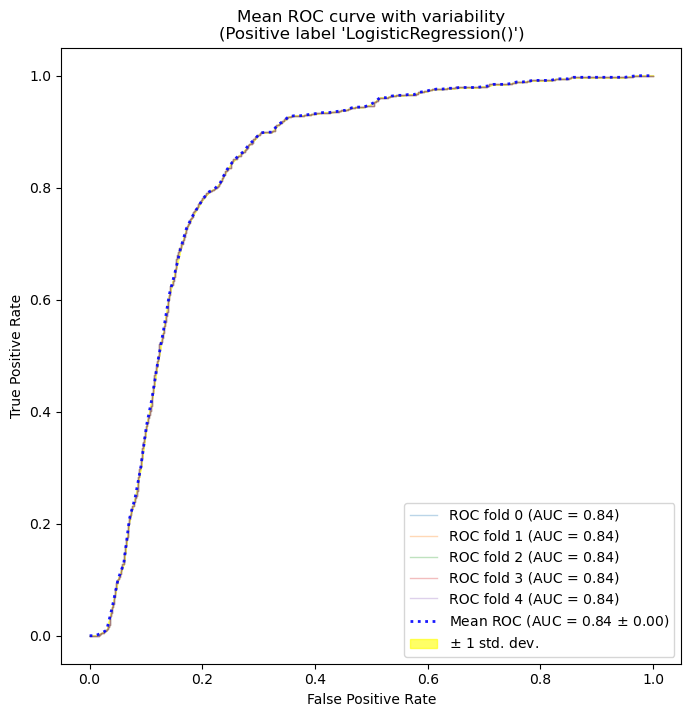

In [48]:
#ROC of Logistic Regression classifier model
Plot_ROC(loReg,skf)

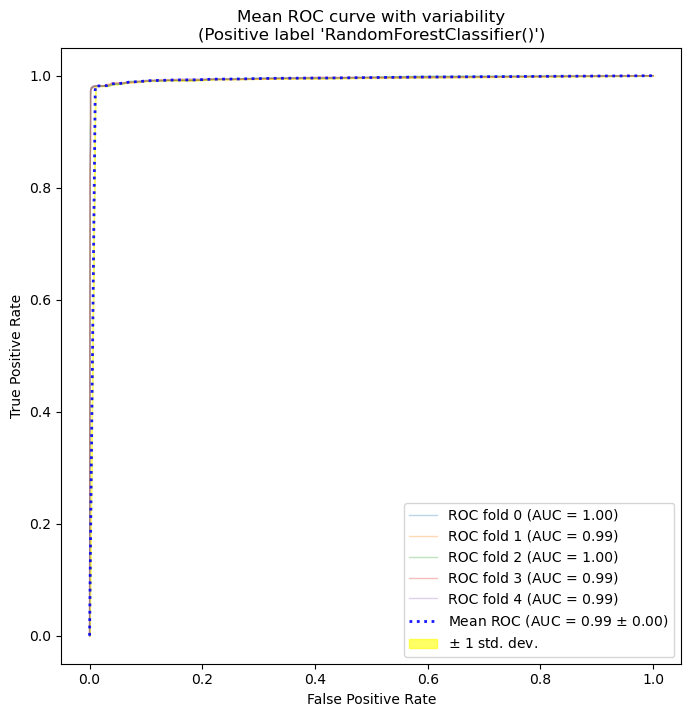

In [49]:
#ROC for Random Forest Classifier
Plot_ROC(RF,skf)

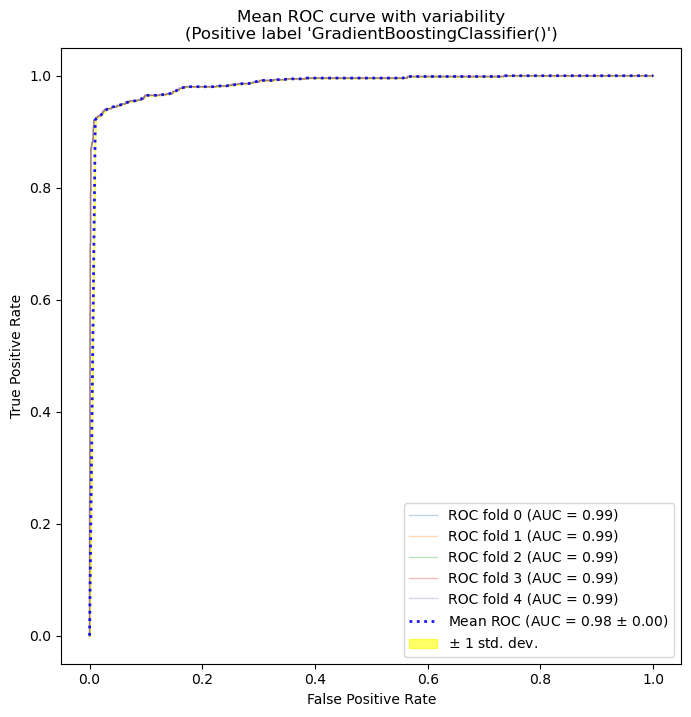

In [50]:
# ROC for Gradient Boosting Classifier
Plot_ROC(gb,skf)

### Test Dataset

In [51]:
# predictions of test dataset
#Logistic regression
y_lr = cross_val_predict(loReg,x_test, y_test,cv=skf)
#Random Forest Classifier
y_rf = cross_val_predict(RF,x_test, y_test,cv=skf)
#Gradient Boosting Classifier
y_gb = cross_val_predict(gb,x_test, y_test,cv=skf)

In [52]:
# Applying test dataset
acc_test = []
roc_test = []

model_used = ['Logistic Regression','Random Forest Classifier','Gradient Boosting Classifier']
y_predictions =[y_lr,y_rf,y_gb]

for i,k in zip(y_predictions,model_used):
    AccT = accuracy_score(y_test,i)
    acc_test.append(AccT)
    rocT=roc_auc_score(y_test,i)
    roc_test.append(rocT)
    print('Confusion Matrix of {} is \n {} '.format(k,confusion_matrix(y_test,i)))
    
print("\n Model performance comparison on test dataset")
model_comparison = pd.DataFrame({'Model': model_used, 'Accuracy': acc_test, 'ROC AUC': roc_test})
model_comparison.sort_values(by='Accuracy', ascending=False)

Confusion Matrix of Logistic Regression is 
 [[2104  182]
 [ 499  215]] 
Confusion Matrix of Random Forest Classifier is 
 [[2275   11]
 [  49  665]] 
Confusion Matrix of Gradient Boosting Classifier is 
 [[2260   26]
 [  55  659]] 

 Model performance comparison on test dataset


,Model,Accuracy,ROC AUC
1,Random Forest Classifier,0.980,0.963280
2,Gradient Boosting Classifier,0.973,0.955798
0,Logistic Regression,0.773,0.610753


In [53]:
# Getting the probability values for each class
prob = cross_val_predict(RF,x_test, y_test,cv=skf, method='predict_proba')
print(prob)

[[1.   0.  ]
 [0.64 0.36]
 [0.99 0.01]
 ...
 [0.91 0.09]
 [0.97 0.03]
 [0.22 0.78]]


In [54]:
# Creating a dataframe with leaving proability values
proba_class1 = prob[:, 1]
y_prob = pd.DataFrame(proba_class1)
y_prob.columns = ['Probability']
y_prob['Employee'] = x_test.index
#y_prob = y_prob.sort_values(by='Probability', ascending=False)
y_prob = y_prob.reset_index(drop=True)
y_prob.head(10)

,Probability,Employee
0,0.00,10627
1,0.36,2703
2,0.01,6059
3,0.00,3258
4,0.00,4565
5,0.02,4991
6,0.07,13976
7,0.00,9427
8,0.01,7173
9,0.00,13412


#### ?Based on the below probability score range, categorize the employees into four zones and suggest your thoughts on the retention strategies for each zone.
Safe Zone (Green) (Score < 20%)
Low Risk Zone (Yellow) (20% < Score < 60%)
Medium Risk Zone (Orange) (60% < Score < 90%)
High Risk Zone (Red) (Score > 90%).

In [55]:
# Categorizing employees
condlst = [y_prob['Probability'] < .2,
           (y_prob['Probability']>= .2)&(y_prob['Probability'] < .6),
           (y_prob['Probability'] >= .6)&(y_prob['Probability'] < .9),
           y_prob['Probability'] >.9]
choicelst = ['Safe',
             'Low Risk',
             'Medium Risk',
             'High Risk']
y_prob['Risk'] = np.select(condlst, choicelst)

#### ? Using the best model, predict the probability of employee turnover in the test data.

In [56]:
predictions = pd.DataFrame(y_pred,columns=['y'])
turnover = ((predictions.y==1).sum()/3000)*100
print("The employee turnover rate is : {} % ".format(turnover))

The employee turnover rate is : 24.099999999999998 % 


In [57]:
# Creating the dataset of test data set with probability and risk category included
Employee_Risk = y_prob.set_index("Employee")
category = pd.merge(Employee_Risk,cleaned_data,left_index=True,right_index=True)
# dropping the left column
category = category.drop('left',axis=1)
category.head()

,Probability,Risk,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary
10627,0.00,Safe,0.98,0.77,3,191,2,0,0,sales,medium
2703,0.36,Low Risk,0.76,0.93,3,271,5,0,0,hr,low
6059,0.01,Safe,0.70,0.93,3,185,4,0,0,accounting,medium
3258,0.00,Safe,0.48,0.61,3,223,3,1,0,support,medium
4565,0.00,Safe,0.57,0.90,3,144,2,0,0,IT,medium


In [58]:
# creating two seperate dataframes for medium and high risk employees
med_risk = category[category.Risk=='Medium Risk']
high_risk = category[category.Risk=='High Risk']

In [59]:
# Filtering objective type data
mo= med_risk.drop('Risk',axis=1).select_dtypes(include=object)
ho= high_risk.drop('Risk',axis=1).select_dtypes(include=object)

#### Medium Risk category

In [60]:
# Analysis of numerical columns in medium risk category
med_risk.describe().T

,count,mean,std,min,25%,50%,75%,max
Probability,113.0,0.791416,0.080765,0.60,0.74,0.80,0.86,0.89
satisfaction_level,113.0,0.589912,0.280008,0.09,0.37,0.74,0.82,0.93
last_evaluation,113.0,0.797522,0.179456,0.45,0.67,0.85,0.94,1.00
number_project,113.0,4.300885,1.322099,2.00,4.00,4.00,5.00,7.00
average_monthly_hours,113.0,224.132743,45.316645,127.00,218.00,238.00,259.00,285.00
time_spend_company,113.0,4.610619,1.097348,2.00,4.00,5.00,5.00,7.00
Work_accident,113.0,0.159292,0.367578,0.00,0.00,0.00,0.00,1.00
promotion_last_5years,113.0,0.008850,0.094072,0.00,0.00,0.00,0.00,1.00


##### Observations
* When we analysis these columns, it's clear that the values are similar to that we observed for the entire dataset.
* Average monthly hours and the number of project have some slight variations in their limits.

In [61]:
# Analysis of object dtype in medium risk category
mo.value_counts(sort=False)

department   salary
IT           high       1
             low        4
             medium     5
RandD        low        5
             medium     3
accounting   low        4
             medium     4
hr           low        3
             medium     2
management   low        2
             medium     2
marketing    high       1
             low        2
             medium     2
product_mng  low        3
             medium     5
sales        high       2
             low       11
             medium    14
support      low        9
             medium     5
technical    high       2
             low       11
             medium    11
Name: count, dtype: int64

In [62]:
# Deparment wise number of employees in medium risk category
mo.department.value_counts()

department
sales          27
technical      24
support        14
IT             10
product_mng     8
RandD           8
accounting      8
marketing       5
hr              5
management      4
Name: count, dtype: int64

In [63]:
# Salary wise number of employees in medium risk category
mo.salary.value_counts()

salary
low       54
medium    53
high       6
Name: count, dtype: int64

##### Observations
* In medium risk category most of the employees are from low or medium salary.
* Employees will definitely leave the organization if their salary is low.
* Most of the employees belongs to sales and technical department.

#### High Risk Category

In [64]:
# Analysis of numerical columns in high risk category
high_risk.describe().T

,count,mean,std,min,25%,50%,75%,max
Probability,543.0,0.980276,0.025056,0.91,0.97,0.99,1.00,1.00
satisfaction_level,543.0,0.399687,0.252662,0.09,0.11,0.40,0.45,0.92
last_evaluation,543.0,0.708932,0.199504,0.45,0.51,0.77,0.91,1.00
number_project,543.0,3.821363,1.934190,2.00,2.00,4.00,6.00,7.00
average_monthly_hours,543.0,205.359116,64.119770,127.00,145.00,219.00,264.00,310.00
time_spend_company,543.0,3.775322,0.901607,3.00,3.00,4.00,4.00,6.00
Work_accident,543.0,0.012891,0.112910,0.00,0.00,0.00,0.00,1.00
promotion_last_5years,543.0,0.003683,0.060634,0.00,0.00,0.00,0.00,1.00


##### Observations
* In high risk category non of the employees got a promotion in last 5 years.
* The minimum value average monthly hours is more than that of the entire dataset.
* The mean value of average monthly hours spent is slighly less than taht of the medium risk category
* The rest of the columns have similar values compared to the entire dataset.

In [65]:
# Analysis of medium risk employees with high salary
exceptions_med = category[(category.Risk=='Medium Risk')&(category.salary=='high')]
exceptions_med

,Probability,Risk,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary
12501,0.66,Medium Risk,0.66,0.57,5,161,5,0,0,technical,high
189,0.80,Medium Risk,0.44,0.51,2,156,3,0,0,technical,high
852,0.67,Medium Risk,0.82,0.89,5,217,5,0,0,sales,high
1476,0.76,Medium Risk,0.79,0.95,5,228,5,0,0,sales,high
14517,0.78,Medium Risk,0.37,0.46,2,149,3,0,0,marketing,high
1515,0.83,Medium Risk,0.72,0.99,5,257,5,0,0,IT,high


In [66]:
# Anlaysis of exceptions in medium risk category
exceptions_med.describe().T

,count,mean,std,min,25%,50%,75%,max
Probability,6.0,0.750000,0.069857,0.66,0.6925,0.77,0.7950,0.83
satisfaction_level,6.0,0.633333,0.186726,0.37,0.4950,0.69,0.7725,0.82
last_evaluation,6.0,0.728333,0.240201,0.46,0.5250,0.73,0.9350,0.99
number_project,6.0,4.000000,1.549193,2.00,2.7500,5.00,5.0000,5.00
average_monthly_hours,6.0,194.666667,45.187019,149.00,157.2500,189.00,225.2500,257.00
time_spend_company,6.0,4.333333,1.032796,3.00,3.5000,5.00,5.0000,5.00
Work_accident,6.0,0.000000,0.000000,0.00,0.0000,0.00,0.0000,0.00
promotion_last_5years,6.0,0.000000,0.000000,0.00,0.0000,0.00,0.0000,0.00


##### Observations
* In medium risk category with high salary, all except one employee worked worked on 5 projects. So they may leave the company due to high work pressure.
* Most of the employees in this group worked for 5 years except for two of them.
* The average monthly hours spend at the comapny is on the higher values, which will impact their work life balance.
* The satisfaction level and last evaluation is varying from person to person.
* The common factor which we can observe is that non of them got a promotion in last 5 years.
* Employees are from techical, sales, IT and marketing category

In [67]:
# Analysis of the object dtype columns in high risk category
ho.value_counts(sort=False)

department   salary
IT           high        1
             low        35
             medium     13
RandD        low         1
             medium      9
accounting   high        1
             low        11
             medium     20
hr           high        2
             low        19
             medium     15
management   low         5
             medium      1
marketing    high        2
             low        23
             medium      6
product_mng  high        1
             low        12
             medium      9
sales        high        1
             low       117
             medium     46
support      high        1
             low        67
             medium     21
technical    high        1
             low        50
             medium     53
Name: count, dtype: int64

In [68]:
# Department wise number of high risk category
ho.department.value_counts()

department
sales          164
technical      104
support         89
IT              49
hr              36
accounting      32
marketing       31
product_mng     22
RandD           10
management       6
Name: count, dtype: int64

In [69]:
# Salary wise number of high risk category
ho.salary.value_counts()

salary
low       340
medium    193
high       10
Name: count, dtype: int64

##### Observations
* High risk category includes employees mostly belonging to low and medium salary. There a few employees with high salary who belongs to RanD, HR, Marketing, Product mng,sales and technical department. 
* Sales department have highest of employees, technical department comes second.
* Here also employees with low salary tends to leave.
* The reasons for employees with high salary leaving the company, may vary from department to department and from person to person also.

In [70]:
# Analysis of high risk employees with high salary
exceptions_high = category[(category.Risk=='High Risk')&(category.salary=='high')]
exceptions_high

,Probability,Risk,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary
14283,0.97,High Risk,0.45,0.49,2,149,3,0,0,product_mng,high
1710,0.97,High Risk,0.11,0.97,6,254,4,0,0,accounting,high
10671,0.98,High Risk,0.37,0.51,2,153,3,0,0,IT,high
111,1.00,High Risk,0.09,0.85,6,289,4,0,0,hr,high
12111,0.98,High Risk,0.09,0.85,6,289,4,0,0,hr,high
12696,0.97,High Risk,0.10,0.81,7,291,4,0,0,sales,high
12657,0.91,High Risk,0.43,0.55,2,130,3,0,0,support,high
12345,0.96,High Risk,0.10,0.86,6,278,4,0,0,technical,high
14751,0.91,High Risk,0.45,0.54,2,129,3,0,0,marketing,high
540,0.91,High Risk,0.45,0.54,2,129,3,0,0,marketing,high


In [71]:
# Anlaysis of exceptions in high risk category
exceptions_high.describe().T

,count,mean,std,min,25%,50%,75%,max
Probability,10.0,0.956,0.033400,0.91,0.9225,0.97,0.9775,1.00
satisfaction_level,10.0,0.264,0.176585,0.09,0.1000,0.24,0.4450,0.45
last_evaluation,10.0,0.697,0.185415,0.49,0.5400,0.68,0.8500,0.97
number_project,10.0,4.100,2.233582,2.00,2.0000,4.00,6.0000,7.00
average_monthly_hours,10.0,209.100,76.075182,129.00,134.7500,203.50,286.2500,291.00
time_spend_company,10.0,3.500,0.527046,3.00,3.0000,3.50,4.0000,4.00
Work_accident,10.0,0.000,0.000000,0.00,0.0000,0.00,0.0000,0.00
promotion_last_5years,10.0,0.000,0.000000,0.00,0.0000,0.00,0.0000,0.00


##### Observations
* When we analyse high risk employees with high salary, it is clear that all of them worked only for 3 -4 years.
* There where three employees with 6 number of projects, who spent really high average monthly hours in the office. They probably will leave due to high work pressure or work life imbalance.
* None of those three got promotion last 5 years, eventhough their last evaluation rating was high. This too may force them to leave the company.
* The satisfaction level of all of these employees were on the lower side.
* Half of them have last evaluation rating quite low.
* Employees are from technical, marketing, hr, sales, IT and accounting department.

### Retention Strategies

* The most common factor which we observed is that, those employees who doesn't got promoted in last 5 years tends to leave the company. If those have high rating is leaving, the company need to take measures to upskill them. 
* In both medium risk and high risk category most of the employees are from sales department. Mostly they will be leaving the company because of salary scale or level of satisfaction. So by implementing a salary increment or some kind of rewards based on their performance will ensure their retention to some extend.
* Those with high salary and high last evaluation rating are leaving mostly because they didn't got promoted last 5 years. Again upskilling and promoting them may ensure their retention.
* Ensuring a balanced work life will improve the satisfaction level of the employees and they will continue to work in the company.

    HR analytics is quite complex. More precise retention stategies can only be put forward after collecting more data from the employees in both medium risk and high risk category. For those who leaving the company for a personal reason we can't do much. We can only apply a holistic approach for retention startegies. From analysis of this dataset satisfaction level and promotion are the two most important factors to be considered for improving retention of employees.